<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Image-classification-with-Twins-Transformer/blob/main/Image_classification_with_Twins_Transformer_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Twins Transformer

**Author:** [LUU THIEN XUAN](https://www.linkedin.com/in/thienxuanluu/)<br>

**Credit:** [Phil Wang](https://github.com/lucidrains)<br>
**Credit:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

Paper
https://arxiv.org/pdf/2104.13840.pdf

Official Code(Pytorch)
https://github.com/Meituan-AutoML/Twins

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [ ]:
!pip install -U tensorflow-addons
!pip install einops

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from einops import rearrange, reduce

## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169017344/169001437 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 512
num_epochs = 40

image_size = 64  # We'll resize input images to this size
patch_size = 4   # Size of the patches to be extract from the input images


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
train_batches = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .cache()
    .shuffle(1000)
    .batch(batch_size,drop_remainder=True)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .cache()
    .batch(batch_size,drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

## Implement patch creation as a layer

In [ ]:
class PatchEmbedding(layers.Layer):
  def __init__(self, dim_out, patch_size, **kwargs):
    super(PatchEmbedding, self).__init__(**kwargs)
    self.dim_out = dim_out
    self.patch_size = patch_size
    self.proj = layers.Conv2D(dim_out, kernel_size=1)
  
  #@tf.function(jit_compile=True)
  def call(self, fmap):
    p = self.patch_size
    fmap = rearrange(fmap, 'b (h p1) (w p2) c -> b h w (c p1 p2)', p1 = p, p2 = p)
    return self.proj(fmap)

## Build the Twins model
Minimally implementation of the paper with close alignement to the author's official implementation.

In [ ]:
#@tf.function(jit_compile=True)
def group_dict_by_key(cond, d):
  return_val = [dict(), dict()]
  for key in d.keys():
    match = bool(cond(key))
    ind = int(not match)
    return_val[ind][key] = d[key]
  return (*return_val,)

#@tf.function(jit_compile=True)
def group_by_key_prefix_and_remove_prefix(prefix, d):
  kwargs_with_prefix, kwargs = group_dict_by_key(lambda x: x.startswith(prefix), d)
  kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
  return kwargs_without_prefix, kwargs

In [ ]:
class Residual(layers.Layer):
  
  def __init__(self, fn):
    super(Residual, self).__init__()
    self.fn = fn

  def call(self, x, **kwargs):
    #print("x", x.get_shape().as_list())
    return self.fn(x, **kwargs) + x

class PEG(layers.Layer): 

  def __init__(self, dim, kernel_size = 3):
    super(PEG, self).__init__()
    
    self.proj = Residual(
        layers.Conv2D(dim, 
                      kernel_size = kernel_size, 
                      padding = "same",
                      groups = dim, 
                      strides = 1
          )
        )
    
  #@tf.function(jit_compile=True)
  def call(self, x):
    return self.proj(x)

In [ ]:
class PreNorm(layers.Layer):

  def __init__(self, fn):
    super(PreNorm, self).__init__()
    self.norm = layers.LayerNormalization(epsilon=1e-6)
    self.fn = fn
  
  #@tf.function(jit_compile=True)
  def call(self, x, **kwargs):
    return self.fn(self.norm(x), **kwargs)

In [ ]:
class FeedForward(layers.Layer):

  def __init__(self, dim, mult = 4, dropout=0.1):
    super(FeedForward, self).__init__()
    self.net =  keras.Sequential([
                    layers.Conv2D(dim * mult, kernel_size=1,activation = tf.nn.gelu),
                    layers.Dropout(dropout),
                    layers.Conv2D(dim, kernel_size=1,activation = tf.nn.gelu),
                    layers.Dropout(dropout)
                    ])

  #@tf.function(jit_compile=True)  
  def call(self, x):
    return self.net(x)

### Attention

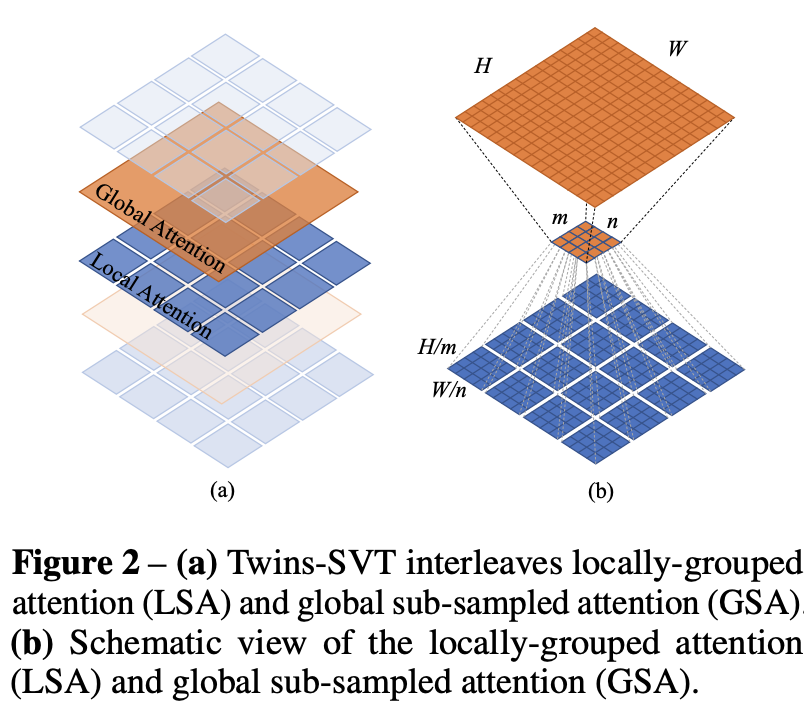

In [ ]:
class LocalAttention(layers.Layer):
  
  def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0., patch_size = 7):
    super(LocalAttention, self).__init__()
    inner_dim = dim_head *  heads
    self.patch_size = patch_size
    self.heads = heads
    self.scale = dim_head ** -0.5

    self.to_q = layers.Conv2D(inner_dim, kernel_size=1, use_bias = False)
    self.to_kv = layers.Conv2D(inner_dim * 2, kernel_size=1, use_bias = False)

    self.to_out = keras.Sequential([
            #layers.Conv2D(dim, kernel_size=1),
            layers.Dense(dim),
            layers.Dropout(dropout)
    ])
    
  #@tf.function(jit_compile=True)
  def call(self, fmap):
    shape, p = fmap.shape, self.patch_size
    b , x, y, n, h = *shape, self.heads
    x, y = map(lambda t: t // p, (x, y))

    fmap = rearrange(fmap, 'b (x p1) (y p2) c -> (b x y) p1 p2 c', p1 = p, p2 = p)
    
    q, (k, v) = self.to_q(fmap), tf.split(self.to_kv(fmap), num_or_size_splits=2, axis=-1)
    q, k, v = map(lambda t: rearrange(t, 'b p1 p2 (h d)-> (b h) (p1 p2) d', h = h), (q, k, v))

    dots = tf.einsum('b i d, b j d -> b i j', q, k) * self.scale

    attn = tf.nn.softmax(dots, axis=-1)

    out = tf.einsum('b i j, b j d -> b i d', attn, v)
    out = rearrange(out, '(b x y h) (p1 p2) d -> b (x p1) (y p2) (h d)', h = h, x = x, y = y, p1 = p, p2 = p)
    return self.to_out(out)

In [ ]:
class GlobalAttention(layers.Layer):

  def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0., k = 7):
    super(GlobalAttention, self).__init__()

    inner_dim = dim_head *  heads
    self.heads = heads
    self.scale = dim_head ** -0.5

    self.to_q = layers.Conv2D(inner_dim, kernel_size=1, use_bias = False)
    self.to_kv = layers.Conv2D(inner_dim * 2, kernel_size=k, strides = k, use_bias = False)

    self.to_out = keras.Sequential([
            #layers.Conv2D(dim, kernel_size=1),
            layers.Dense(dim),
            layers.Dropout(dropout)
        ])
  
  #@tf.function(jit_compile=True)
  def call(self, x):
    shape = x.shape
    b, _, y, n, h = *shape, self.heads
    
    q, (k, v) = self.to_q(x), tf.split(self.to_kv(x), num_or_size_splits=2, axis=-1)

    q, k, v = map(lambda t: rearrange(t, 'b x y (h d) -> (b h) (x y) d', h = h), (q, k, v))

    dots = tf.einsum('b i d, b j d -> b i j', q, k) * self.scale

    attn = tf.nn.softmax(dots, axis=-1)

    out = tf.einsum('b i j, b j d -> b i d', attn, v)
    out = rearrange(out, '(b h) (x y) d -> b x y (h d)', h = h, y = y)
    return self.to_out(out)

### Transformer

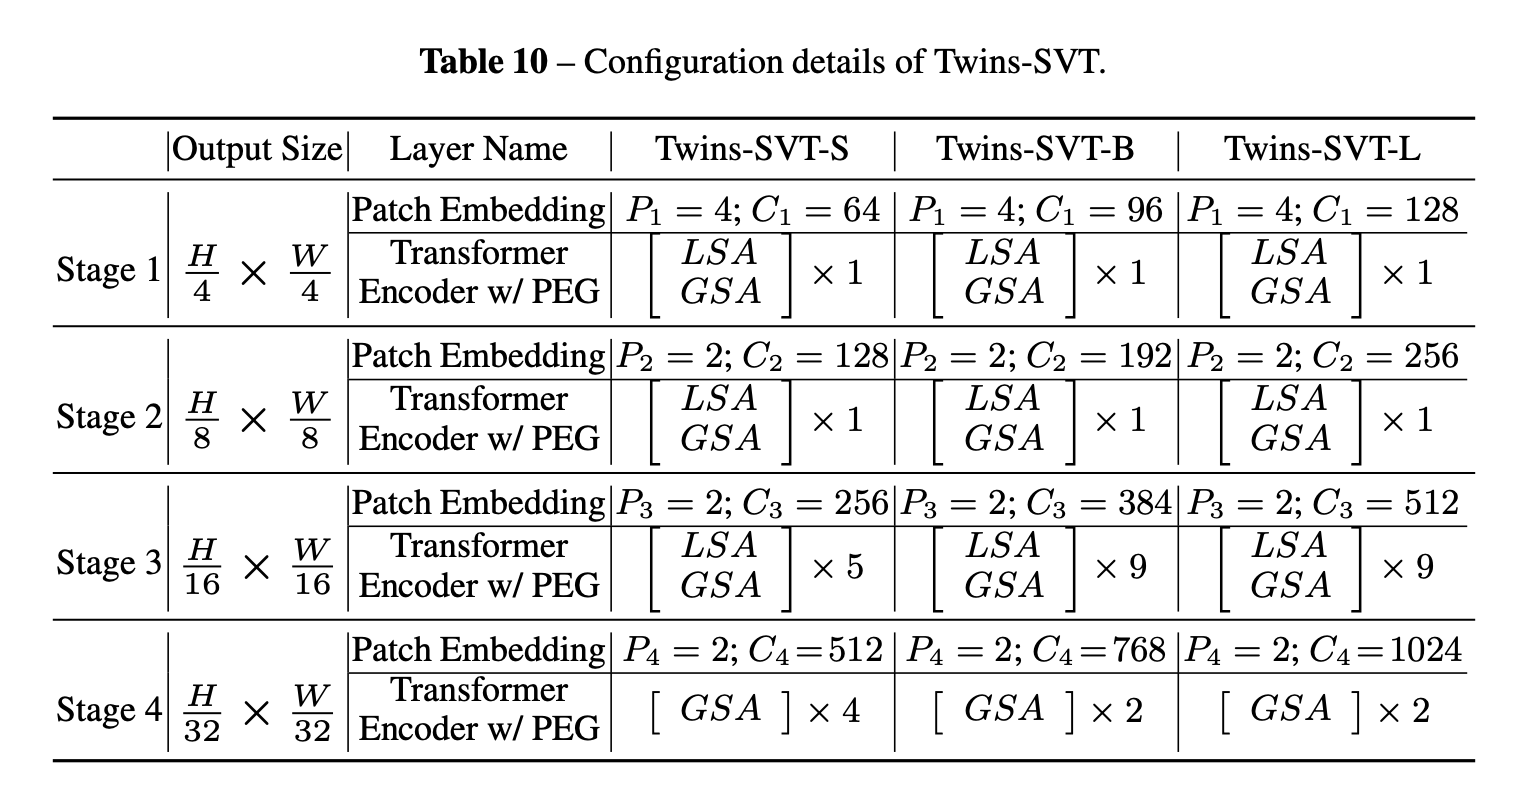

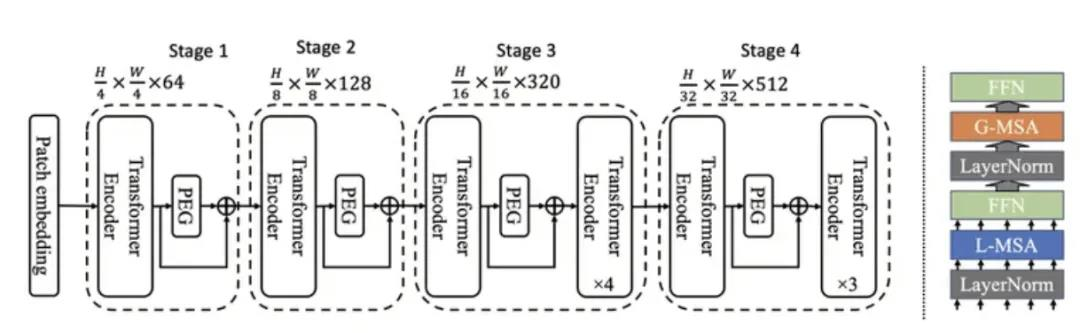

In [ ]:
class Transformer(layers.Layer):

  def __init__(self, dim, depth, heads = 8, dim_head = 64, mlp_mult = 4, local_patch_size = 7, global_k = 7, dropout = 0., has_local = True):
    super(Transformer, self).__init__()

    self.layers = []
    for _ in range(depth):
      self.layers.append(
          [
            Residual(PreNorm(LocalAttention(dim, heads = heads, dim_head = dim_head, dropout = dropout, patch_size = local_patch_size))) if has_local else [],
            Residual(PreNorm(FeedForward(dim, mlp_mult, dropout = dropout))) if has_local else [],
            Residual(PreNorm(GlobalAttention(dim, heads = heads, dim_head = dim_head, dropout = dropout, k = global_k))),
            Residual(PreNorm(FeedForward(dim, mlp_mult, dropout = dropout)))
          ]
        )

  #@tf.function(jit_compile=True) 
  def call(self, x):
    for local_attn, ff1, global_attn, ff2 in self.layers:
      if local_attn : x = local_attn(x)
      if ff1 :x = ff1(x)
      x = global_attn(x)
      x = ff2(x)
    return x

In [ ]:
class TwinsSVT(layers.Layer):

  def __init__(self,*,
      num_classes,
      s1_emb_dim = 64 ,s1_patch_size = 4,s1_local_patch_size = 7,s1_global_k = 7,s1_depth = 1,
      s2_emb_dim = 128,s2_patch_size = 2,s2_local_patch_size = 7,s2_global_k = 7,s2_depth = 1,
      s3_emb_dim = 256,s3_patch_size = 2,s3_local_patch_size = 7,s3_global_k = 7,s3_depth = 5,
      s4_emb_dim = 512,s4_patch_size = 2,s4_local_patch_size = 7,s4_global_k = 7,s4_depth = 4,
      peg_kernel_size = 3,dropout = 0.
      ):  
    super(TwinsSVT, self).__init__()
    
    kwargs = dict(locals())

    dim = 3
    glayers = []

    for prefix in ('s1', 's2', 's3', 's4'):
      config, kwargs = group_by_key_prefix_and_remove_prefix(f'{prefix}_', kwargs)
      is_last = prefix == 's4'

      dim_next = config['emb_dim']

      glayers.extend([
                      
          PatchEmbedding(dim_out = dim_next, 
                         patch_size = config['patch_size']),

          Transformer(dim = dim_next, 
                      depth = 1, 
                      local_patch_size = config['local_patch_size'], 
                      global_k = config['global_k'], 
                      dropout = dropout, 
                      has_local = not is_last),
          
          PEG(dim = dim_next, 
              kernel_size = peg_kernel_size),
          
          Transformer(dim = dim_next, 
                      depth = config['depth'], 
                      local_patch_size = config['local_patch_size'], 
                      global_k = config['global_k'], 
                      dropout = dropout, 
                      has_local = not is_last)
          
      ])

      #dim = dim_next

    self.layers = keras.Sequential([
            *glayers,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes)
    ])
  
  #@tf.function(jit_compile=True)
  def call(self, x):
    return self.layers(x)

In [ ]:
class TwinsSVT_small(layers.Layer):

  def __init__(self,*,
      num_classes,
      s1_emb_dim = 64 ,s1_patch_size = 4,s1_local_patch_size = 7,s1_global_k = 7,s1_depth = 1,
      s2_emb_dim = 128,s2_patch_size = 2,s2_local_patch_size = 7,s2_global_k = 7,s2_depth = 1,
      s3_emb_dim = 256,s3_patch_size = 2,s3_local_patch_size = 7,s3_global_k = 7,s3_depth = 5,
      peg_kernel_size = 3,dropout = 0.
      ):  
    super(TwinsSVT_small, self).__init__()
    
    kwargs = dict(locals())

    dim = 3
    glayers = []

    for prefix in ('s1', 's2', 's3'):
      config, kwargs = group_by_key_prefix_and_remove_prefix(f'{prefix}_', kwargs)
      is_last = prefix == 's3'

      dim_next = config['emb_dim']

      glayers.extend([
                                      
          PatchEmbedding(dim_out = dim_next, 
                         patch_size = config['patch_size']),

          Transformer(dim = dim_next, 
                      depth = 1, 
                      local_patch_size = config['local_patch_size'], 
                      global_k = config['global_k'], 
                      dropout = dropout, 
                      has_local = not is_last),
          
          PEG(dim = dim_next, 
              kernel_size = peg_kernel_size),
          
          Transformer(dim = dim_next, 
                      depth = config['depth'], 
                      local_patch_size = config['local_patch_size'], 
                      global_k = config['global_k'], 
                      dropout = dropout, 
                      has_local = not is_last)
          
      ])

      #dim = dim_next

    self.layers = keras.Sequential([
            *glayers,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes)
    ])
  
  #@tf.function(jit_compile=True)
  def call(self, x):
    return self.layers(x)

### Debug model

In [ ]:
model = TwinsSVT(
    num_classes = 1000,       # number of output classes
    
    s1_emb_dim = 64,          # stage 1 - patch embedding projected dimension
    s1_patch_size = 4,        # stage 1 - patch size for patch embedding
    s1_local_patch_size = 7,  # stage 1 - patch size for local attention
    s1_global_k = 7,          # stage 1 - global attention key / value reduction factor, defaults to 7 as specified in paper
    s1_depth = 1,             # stage 1 - number of transformer blocks (local attn -> ff -> global attn -> ff)
    
    s2_emb_dim = 128,         # stage 2 (same as above)
    s2_patch_size = 2,
    s2_local_patch_size = 7,
    s2_global_k = 7,
    s2_depth = 1,
    
    s3_emb_dim = 256,         # stage 3 (same as above)
    s3_patch_size = 2,
    s3_local_patch_size = 7,
    s3_global_k = 7,
    s3_depth = 5,
    
    s4_emb_dim = 512,         # stage 4 (same as above)
    s4_patch_size = 2,
    s4_local_patch_size = 7,
    s4_global_k = 7,
    s4_depth = 4,
    
    peg_kernel_size = 3,      # positional encoding generator kernel size
    dropout = 0.              # dropout
)
model.build(input_shape=(1,224,224,3))

img = tf.random.uniform(shape=[1, 224, 224, 3])
preds = model(img)
print(preds.shape) # (1, 1000)

## Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model):
  
  optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

  model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

  history = model.fit(
        train_batches,
        batch_size=batch_size,
        steps_per_epoch = len(x_train)//batch_size,
        epochs=num_epochs,
        validation_data=val_batches,
        validation_steps= len(x_test)//batch_size, 
    )

  return history

In [ ]:
class twins_classifier(keras.Model):
  
  def __init__(self):
    
    super(twins_classifier, self).__init__()
    self.aug = data_augmentation
    self.twins = TwinsSVT_small(
                  num_classes = num_classes,       
                  s1_emb_dim = 64,          
                  s1_patch_size = 4,        # stage 1 - patch size for patch embedding
                  s1_local_patch_size = patch_size,  
                  s1_global_k = patch_size,          
                  s1_depth = 1,             
                  
                  s2_emb_dim = 128,         # stage 2 (same as above)
                  s2_patch_size = 2,
                  s2_local_patch_size = patch_size,
                  s2_global_k = patch_size,
                  s2_depth = 1,

                  s3_emb_dim = 256,         # stage 3 (same as above)
                  s3_patch_size = 2,
                  s3_local_patch_size = patch_size,
                  s3_global_k = patch_size,
                  s3_depth = 5,
                                    
                  peg_kernel_size = 3,      # positional encoding generator kernel size
                  dropout = 0.              # dropout
              )
      
  def call(self, inputs):
    x = self.aug(inputs)
    return self.twins(x)

In [ ]:
classifier = twins_classifier()
classifier.build(input_shape=(batch_size,32,32,3))
history = run_experiment(classifier)

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.